In [2]:
import tensorflow as tf
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
# % matplotlib inline
np.random.seed(2019) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout,GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras.models import Model

In [3]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


In [4]:
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


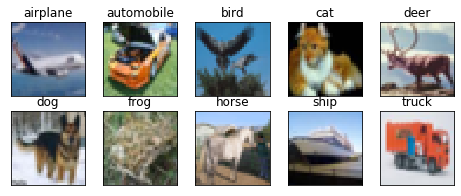

In [5]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [6]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [7]:
# function to calculate accuracy of prediction
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [8]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

##### importing the resnet model

In [9]:
from keras.initializers import glorot_uniform
import keras

def resnet_block(x, conv_channel_size, output_size, stride_size):
    # todo add arguments
    """
  Args:

  """
    # bn follwedby relu
    x_original = x
    x = bn_with_relu(x)
    # conv
    x = keras.layers.Conv2D(conv_channel_size,
                            3,
                            padding='same',
                            strides=stride_size[0],
                            kernel_initializer=glorot_uniform(seed=0))(x)
    # # bn follwedby relu
    x = bn_with_relu(x)
    # conv
    x = keras.layers.Conv2D(conv_channel_size,
                            3,
                            padding='same',
                            strides=stride_size[1],
                            kernel_initializer=glorot_uniform(seed=0))(x)
    # if channel size doesn't match we can't add
    # so perform 1x1 to get required channel size
    if output_size != 'same':
        identity_tensor = keras.layers.Conv2D(
            conv_channel_size,
            1,
            padding='same',
            strides=stride_size[0],
            kernel_initializer=glorot_uniform(seed=0))(x_original)
        identity_tensor = keras.layers.BatchNormalization()(identity_tensor)
    else:
        identity_tensor = x_original
    x = keras.layers.add([x, identity_tensor])
    return x


def bn_with_relu(x):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(tf.nn.relu)(x)
    return x

input_shape = (img_rows,img_cols,img_channels)
input_tensor = keras.layers.Input(input_shape)
x = keras.layers.Conv2D(16, 3, padding='same',kernel_initializer=glorot_uniform(seed=0))(input_tensor)
# todo add comments
x  = resnet_block(x,16,'not_same',[1,1])
x  = resnet_block(x,16,'same',[1,1])
x  = resnet_block(x,32,'not_same',[1,1])
x  = resnet_block(x,32,'same',[1,1])

# x  = tfk.layers.MaxPooling2D(2,2)(x)
x  = resnet_block(x,64,'not_same',[2,1])
x  = resnet_block(x,64,'same',[1,1])

# x  = tfk.layers.MaxPooling2D(2,2)(x)
x  = resnet_block(x,128,'not_same',[2,1])
x  = resnet_block(x,128,'same',[1,1])

x = keras.layers.Conv2D(10,1, kernel_initializer=glorot_uniform(seed=0))(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Activation(tf.nn.softmax)(x)
model = keras.models.Model(input_tensor,x)
model.summary()

W1117 23:35:50.548286 139757282764608 deprecation_wrapper.py:119] From /home/paperspace/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1117 23:35:50.572877 139757282764608 deprecation_wrapper.py:119] From /home/paperspace/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1117 23:35:50.578984 139757282764608 deprecation_wrapper.py:119] From /home/paperspace/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1117 23:35:50.609857 139757282764608 deprecation_wrapper.py:119] From /home/paperspace/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_defaul

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

#### Defining all the pre-processing functions

In [10]:
# initializing the mean and standard deviation matrix for image normalization
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

In [11]:
def train_preprocessing(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    # code for image normalization
    def image_normalization(input_img):
      input_img = input_img - mean
      input_img = input_img/std
      return input_img

    def pad_image(input_img, padding_size):
      # input_img = numpy(inut_img)
      input_img_1 = input_img[:,:,0]
      input_img_2 = input_img[:,:,1]
      input_img_3 = input_img[:,:,2]
      input_img_1 = np.pad(input_img_1, (padding_size, padding_size), 'reflect')
      input_img_2 = np.pad(input_img_2, (padding_size, padding_size), 'reflect')
      input_img_3 = np.pad(input_img_3, (padding_size, padding_size), 'reflect')

      input_img = np.dstack((input_img_1, input_img_2, input_img_3))

      # input_img = np.pad(input_img, (padding_size, padding_size), 'reflect')
      # print("................................")
      # print(input_img.shape)
      return input_img
      
    
    def random_crop(input_img, random_crop_size):
      # Note: image_data_format is 'channel_last'
      # assert input_img.shape[2] == 3
      height, width = input_img.shape[0], input_img.shape[1]
      dy, dx = random_crop_size
      x = np.random.randint(0, width - dx + 1)
      y = np.random.randint(0, height - dy + 1)
      return input_img[y:(y+dy), x:(x+dx), :]
    
    def eraser(input_img):
        input_img = image_normalization(input_img)
        input_img = pad_image(input_img, 4)
        input_img = random_crop(input_img, (32, 32))
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [12]:
def test_preprocessing():
  def image_normalization(input_img):
    input_img = input_img - mean
    input_img = input_img/std
    return input_img
  return image_normalization

W1117 23:36:31.694386 139757282764608 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


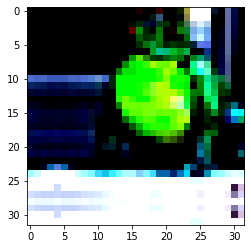

In [13]:
# visualizing the train preprocessing
eraser = train_preprocessing()

img = eraser(train_features[19])
plt.imshow(img)

#### Code for LRFinder

In [0]:
# code for finding the best learning rate, which will be used as a call back in model.fit function
class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

In [0]:
# initiating object lr_finder from LR_Finder class
lr_finder = LR_Finder(start_lr=1e-7, end_lr=10, step_size=np.ceil(train_features.shape[0]/128))

# Create datagenerate for training
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,preprocessing_function=train_preprocessing(v_l=0.1, v_h=0.3))

model.compile(optimizer = 'SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
start = time.time()
# Train the model
model.fit(train_features, train_labels, batch_size=128, callbacks=[lr_finder])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))


Epoch 1/1
47488/50000 [===========================>..] - ETA: 0s - loss: 4.3777 - accuracy: 0.1225Model took 17.53 seconds to train


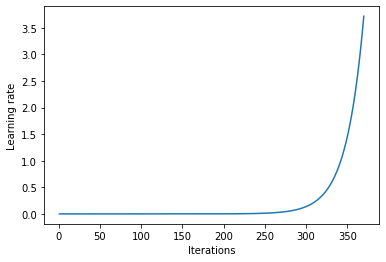

In [0]:
lr_finder.plot_lr()

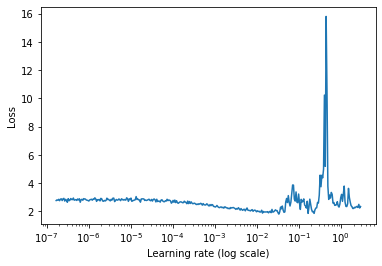

In [0]:
lr_finder.plot()

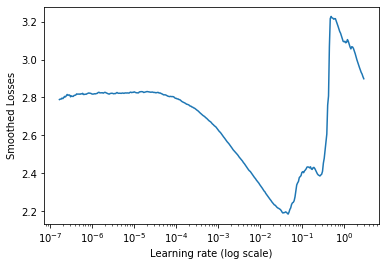

In [0]:
lr_finder.plot_smoothed_loss()

In [14]:
# Code is ported from https://github.com/fastai/fastai
class OneCycleLR(Callback):
    def __init__(self,
                 max_lr,
                 end_percentage=0.1,
                 scale_percentage=None,
                 maximum_momentum=0.95,
                 minimum_momentum=0.85,
                 verbose=True):
        """ This callback implements a cyclical learning rate policy (CLR).
        This is a special case of Cyclic Learning Rates, where we have only 1 cycle.
        After the completion of 1 cycle, the learning rate will decrease rapidly to
        100th its initial lowest value.
        # Arguments:
            max_lr: Float. Initial learning rate. This also sets the
                starting learning rate (which will be 10x smaller than
                this), and will increase to this value during the first cycle.
            end_percentage: Float. The percentage of all the epochs of training
                that will be dedicated to sharply decreasing the learning
                rate after the completion of 1 cycle. Must be between 0 and 1.
            scale_percentage: Float or None. If float, must be between 0 and 1.
                If None, it will compute the scale_percentage automatically
                based on the `end_percentage`.
            maximum_momentum: Optional. Sets the maximum momentum (initial)
                value, which gradually drops to its lowest value in half-cycle,
                then gradually increases again to stay constant at this max value.
                Can only be used with SGD Optimizer.
            minimum_momentum: Optional. Sets the minimum momentum at the end of
                the half-cycle. Can only be used with SGD Optimizer.
            verbose: Bool. Whether to print the current learning rate after every
                epoch.
        # Reference
            - [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, weight_decay, and weight decay](https://arxiv.org/abs/1803.09820)
            - [Super-Convergence: Very Fast Training of Residual Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120)
        """
        super(OneCycleLR, self).__init__()

        if end_percentage < 0. or end_percentage > 1.:
            raise ValueError("`end_percentage` must be between 0 and 1")

        if scale_percentage is not None and (scale_percentage < 0. or scale_percentage > 1.):
            raise ValueError("`scale_percentage` must be between 0 and 1")

        self.initial_lr = max_lr
        self.end_percentage = end_percentage
        self.scale = float(scale_percentage) if scale_percentage is not None else float(end_percentage)
        self.max_momentum = maximum_momentum
        self.min_momentum = minimum_momentum
        self.verbose = verbose

        if self.max_momentum is not None and self.min_momentum is not None:
            self._update_momentum = True
        else:
            self._update_momentum = False

        self.clr_iterations = 0.
        self.history = {}

        self.epochs = None
        self.batch_size = None
        self.samples = None
        self.steps = None
        self.num_iterations = None
        self.mid_cycle_id = None

    def _reset(self):
        """
        Reset the callback.
        """
        self.clr_iterations = 0.
        self.history = {}

    def compute_lr(self):
        """
        Compute the learning rate based on which phase of the cycle it is in.
        - If in the first half of training, the learning rate gradually increases.
        - If in the second half of training, the learning rate gradually decreases.
        - If in the final `end_percentage` portion of training, the learning rate
            is quickly reduced to near 100th of the original min learning rate.
        # Returns:
            the new learning rate
        """
        if self.clr_iterations > 2 * self.mid_cycle_id:
            current_percentage = (self.clr_iterations - 2 * self.mid_cycle_id)
            current_percentage /= float((self.num_iterations - 2 * self.mid_cycle_id))
            new_lr = self.initial_lr * (1. + (current_percentage *
                                              (1. - 100.) / 100.)) * self.scale

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - (
                self.clr_iterations - self.mid_cycle_id) / self.mid_cycle_id
            new_lr = self.initial_lr * (1. + current_percentage *
                                        (self.scale * 100 - 1.)) * self.scale

        else:
            current_percentage = self.clr_iterations / self.mid_cycle_id
            new_lr = self.initial_lr * (1. + current_percentage *
                                        (self.scale * 100 - 1.)) * self.scale

        if self.clr_iterations == self.num_iterations:
            self.clr_iterations = 0

        return new_lr

    def compute_momentum(self):
        """
         Compute the momentum based on which phase of the cycle it is in.
        - If in the first half of training, the momentum gradually decreases.
        - If in the second half of training, the momentum gradually increases.
        - If in the final `end_percentage` portion of training, the momentum value
            is kept constant at the maximum initial value.
        # Returns:
            the new momentum value
        """
        if self.clr_iterations > 2 * self.mid_cycle_id:
            new_momentum = self.max_momentum

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - ((self.clr_iterations - self.mid_cycle_id) / float(
                                        self.mid_cycle_id))
            new_momentum = self.max_momentum - current_percentage * (
                self.max_momentum - self.min_momentum)

        else:
            current_percentage = self.clr_iterations / float(self.mid_cycle_id)
            new_momentum = self.max_momentum - current_percentage * (
                self.max_momentum - self.min_momentum)

        return new_momentum

    def on_train_begin(self, logs={}):
        logs = logs or {}

        self.epochs = 100
        self.batch_size = 512
        self.samples = 50000
        # self.steps = self.params['steps']

        if self.steps is not None:
            self.num_iterations = self.epochs * self.steps
        else:
            if (self.samples % self.batch_size) == 0:
                remainder = 0
            else:
                remainder = 1
            self.num_iterations = (self.epochs + remainder) * self.samples // self.batch_size

        self.mid_cycle_id = int(self.num_iterations * ((1. - self.end_percentage)) / float(2))

        self._reset()
        K.set_value(self.model.optimizer.lr, self.compute_lr())

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()
            K.set_value(self.model.optimizer.momentum, new_momentum)

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}

        self.clr_iterations += 1
        new_lr = self.compute_lr()

        self.history.setdefault('lr', []).append(
            K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()

            self.history.setdefault('momentum', []).append(
                K.get_value(self.model.optimizer.momentum))
            K.set_value(self.model.optimizer.momentum, new_momentum)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            if self._update_momentum:
                print(" - lr: %0.5f - momentum: %0.2f " %
                      (self.history['lr'][-1], self.history['momentum'][-1]))

            else:
                print(" - lr: %0.5f " % (self.history['lr'][-1]))

In [15]:
# initializing the callback
one_cycle_lr = OneCycleLR(            
                          max_lr=0.01,
                          end_percentage=0.1,
                          scale_percentage=None,
                          maximum_momentum=0.95,
                          minimum_momentum=0.85,
                          verbose=True)

In [21]:
################### Define the checkpoints ###################

# base_dir = '/content/drive/My Drive/EVA/Session13'
import os
base_dir = os.getcwd()

import os
if not (os.path.exists(os.path.join(base_dir, 'weights_onecycle'))):
    os.mkdir(os.path.join(base_dir, 'weights_onecycle'))

filepath = os.path.join(base_dir,
                        'weights_onecycle/weights-improvement-cutout-best.hdf5')

checkpoint = ModelCheckpoint(filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max')


In [22]:
train_datagen = ImageDataGenerator(zoom_range=0.0, 
                              horizontal_flip=True,preprocessing_function=train_preprocessing(v_l=0.1, v_h=0.3))
test_datagen = ImageDataGenerator(zoom_range=0.0,
                              horizontal_flip=True, preprocessing_function=test_preprocessing())

model.compile(optimizer = 'SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
# train the model
start = time.time()
# Train the model
bs = 512
steps_train = train_features.shape[0] // bs
val_steps = test_features.shape[0] // bs
model_info = model.fit_generator(train_datagen.flow(train_features, train_labels, batch_size = bs),
                                 steps_per_epoch = steps_train,
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 300, 
                                 validation_data = test_datagen.flow(test_features, test_labels, batch_size=bs),
                                 validation_steps = val_steps,
                                 verbose=1, callbacks=[one_cycle_lr, checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

/home/paperspace/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/home/paperspace/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=97, validation_data=<keras_pre..., validation_steps=19, verbose=1, callbacks=[<__main__..., epochs=300)`
  if sys.path[0] == '':


Epoch 1/300
97/97 [==============================] - 14s 147ms/step - loss: 1.4894 - acc: 0.4551 - val_loss: 1.5205 - val_acc: 0.4219
 - lr: 0.00119 - momentum: 0.95 

Epoch 00001: val_acc improved from -inf to 0.42188, saving model to /home/paperspace/Desktop/test/EVA-/EVA_Assignment_13/weights_onecycle/weights-improvement-cutout-best.hdf5
Epoch 2/300
97/97 [==============================] - 12s 125ms/step - loss: 1.4355 - acc: 0.4762 - val_loss: 1.4161 - val_acc: 0.4752
 - lr: 0.00139 - momentum: 0.95 

Epoch 00002: val_acc improved from 0.42188 to 0.47523, saving model to /home/paperspace/Desktop/test/EVA-/EVA_Assignment_13/weights_onecycle/weights-improvement-cutout-best.hdf5
Epoch 3/300
97/97 [==============================] - 13s 136ms/step - loss: 1.3808 - acc: 0.4993 - val_loss: 1.4643 - val_acc: 0.4720
 - lr: 0.00159 - momentum: 0.94 

Epoch 00003: val_acc did not improve from 0.47523
Epoch 4/300
97/97 [==============================] - 13s 136ms/step - loss: 1.3276 - acc: 0.5

97/97 [==============================] - 13s 135ms/step - loss: 0.6830 - acc: 0.7573 - val_loss: 0.7748 - val_acc: 0.7508
 - lr: 0.00690 - momentum: 0.88 

Epoch 00030: val_acc improved from 0.74515 to 0.75084, saving model to /home/paperspace/Desktop/test/EVA-/EVA_Assignment_13/weights_onecycle/weights-improvement-cutout-best.hdf5
Epoch 31/300
96/97 [============================>.] - ETA: 0s - loss: 0.6676 - acc: 0.7652

KeyboardInterrupt: 

In [0]:
# train the model
start = time.time()
# Train the model
bs = 512
steps_train = train_features.shape[0] // bs
val_steps = test_features.shape[0] // bs
model_info = model.fit_generator(train_datagen.flow(train_features, train_labels, batch_size = bs),
                                 steps_per_epoch = steps_train,
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 300, 
                                 validation_data = test_datagen.flow(test_features, test_labels, batch_size=bs),
                                 validation_steps = val_steps,
                                 verbose=1, callbacks=[one_cycle_lr])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))